# Problem 1

For the Reuter data that we analyzed in class, we did not compare the deep learning results
with any baseline. Please compare the results with Multiclass Logistic Regression, which can
serve as a baseline. Report your findings and submit the Python code as an appendix. (You can
fit a multiclass logistic regression by modifying the code for Reuter data slightly.)


In [22]:

from keras.datasets import reuters
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

(num_words,) = (10000,)
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=num_words)

def vectorize_sequences(sequences, dimension=num_words):
    results = np.zeros((len(sequences), dimension), dtype='float32')
    for i, seq in enumerate(sequences):
        results[i, seq] = 1.0
    return results

X_train = vectorize_sequences(train_data)
X_test  = vectorize_sequences(test_data)
y_train = train_labels
y_test  = test_labels

logreg = LogisticRegression(
    solver='lbfgs',
    max_iter=1000,
    n_jobs=-1
)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
acc      = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"Baseline Logistic Regression")
print(f"  Test accuracy:    {acc:.4f}")
print(f"  Macro F1-score:   {f1_macro:.4f}")
print(f"  Weighted F1-score:{f1_weighted:.4f}")


Baseline Logistic Regression
  Test accuracy:    0.7925
  Macro F1-score:   0.5666
  Weighted F1-score:0.7816


Conclusion: The deep learning model outperforms the simple multinomial logistic regression by roughly 23 percentage points in overall accuracy, demonstrating that the network’s hidden representations capture topic distinctions that the linear baseline cannot.

# Question 2

In this problem, you will analyze an SMS spam dataset collected from
https://dl.acm.org/doi/10.1145/2034691.2034742. The dataset contains both legitimate SMS
messages (labeled as “ham”) and spam messages (labeled as “spam”). I have prepared a data
matrix where the (𝑖, 𝑗)-th element represents the count of the j-th word in the i-th message. I
have included words that appear in at least 1% of the messages. Your task is to build a deep
neural network model to classify “ham” and “spam” messages. Write a short report about your
analysis. Consider the following questions: Have you compared the results with random
guessing or baselines? Is the metric “accuracy” a good choice for this analysis? The dataset
“messages.csv” is attached.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score, auc, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

# Load data
df = pd.read_csv('Data/messages.csv')


# Prepare features and labels
X = df.drop('V1', axis=1).values
y = df['V1'].map({'ham': 0, 'spam': 1}).values

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Baseline: random guessing based on training spam proportion
spam_prob = y_train.mean()
rng = np.random.RandomState(42)
y_pred_random = rng.rand(len(y_test)) < spam_prob

# Multiclass Logistic Regression baseline
lr = LogisticRegression(solver='lbfgs', max_iter=1000, n_jobs=-1)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:, 1]

# Deep Neural Network
input_dim = X_train.shape[1]
model = Sequential([
    Dense(64, activation='relu', input_dim=input_dim),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, callbacks=[es], verbose=0)
y_prob_nn = model.predict(X_test).ravel()
y_pred_nn = y_prob_nn > 0.5

# Metric computation
def compute_metrics(y_true, y_pred, y_prob=None):
    m = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1_score': f1_score(y_true, y_pred)
    }
    if y_prob is not None:
        m['roc_auc'] = roc_auc_score(y_true, y_prob)
    return m

metrics_random = compute_metrics(y_test, y_pred_random, np.full_like(y_test, spam_prob))
metrics_lr = compute_metrics(y_test, y_pred_lr, y_prob_lr)
metrics_nn = compute_metrics(y_test, y_pred_nn, y_prob_nn)

# Compile results
metrics_df = pd.DataFrame(
    [metrics_random, metrics_lr, metrics_nn],
    index=['Random Guessing', 'Logistic Regression', 'Neural Network']
)

# Display results
display("Model Comparison Metrics", metrics_df)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


'Model Comparison Metrics'

,accuracy,precision,recall,f1_score,roc_auc
Random Guessing,0.758744,0.125000,0.134228,0.129450,0.500000
Logistic Regression,0.986547,1.000000,0.899329,0.946996,0.986779
Neural Network,0.985650,0.985401,0.906040,0.944056,0.979268


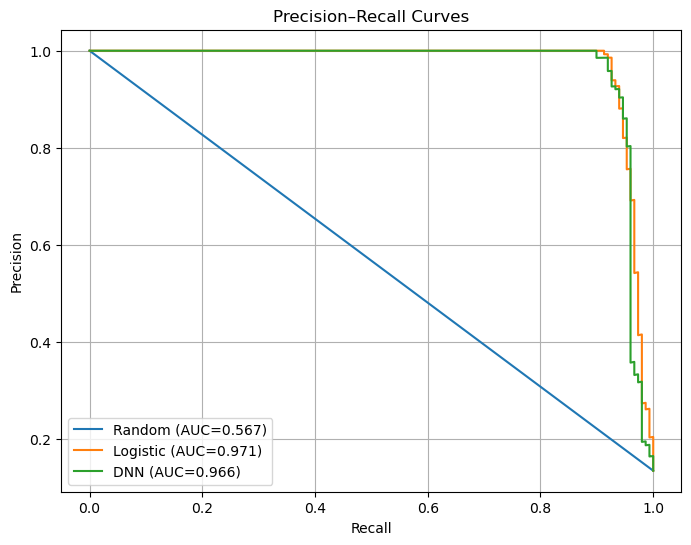

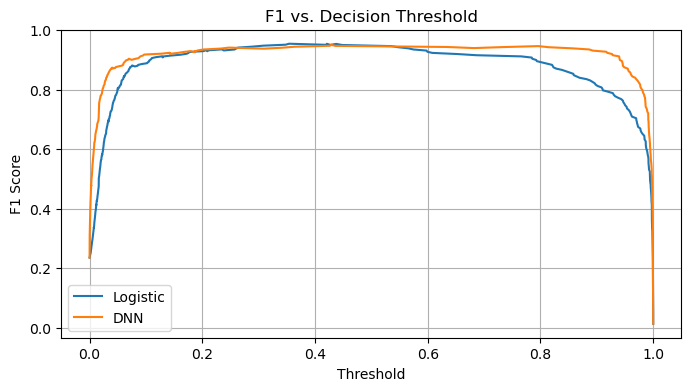

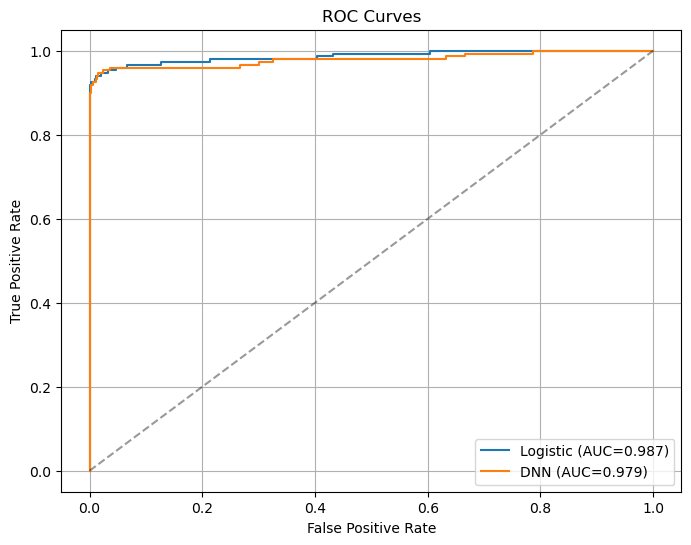


Random Confusion Matrix:
[[826 140]
 [129  20]]
Balanced Accuracy: 0.495
              precision    recall  f1-score   support

           0     0.8649    0.8551    0.8600       966
           1     0.1250    0.1342    0.1294       149

    accuracy                         0.7587      1115
   macro avg     0.4950    0.4947    0.4947      1115
weighted avg     0.7660    0.7587    0.7623      1115


Logistic Confusion Matrix:
[[966   0]
 [ 15 134]]
Balanced Accuracy: 0.950
              precision    recall  f1-score   support

           0     0.9847    1.0000    0.9923       966
           1     1.0000    0.8993    0.9470       149

    accuracy                         0.9865      1115
   macro avg     0.9924    0.9497    0.9696      1115
weighted avg     0.9868    0.9865    0.9862      1115


DNN Confusion Matrix:
[[964   2]
 [ 14 135]]
Balanced Accuracy: 0.952
              precision    recall  f1-score   support

           0     0.9857    0.9979    0.9918       966
           1    

In [2]:


plt.figure(figsize=(8, 6))
for name, y_prob in [
    ("Random", np.full_like(y_test, spam_prob)),
    ("Logistic", y_prob_lr),
    ("DNN",      y_prob_nn)
]:
    prec, rec, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(rec, prec)
    plt.plot(rec, prec, label=f"{name} (AUC={pr_auc:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall Curves"); plt.legend()
plt.grid(True)
plt.show()

# 2) F1‐Score vs. Threshold (for LR and DNN)
def plot_f1_vs_thresh(y_true, y_prob, name):
    prec, rec, thresh = precision_recall_curve(y_true, y_prob)
    f1 = 2 * (prec*rec) / (prec+rec+1e-8)
    plt.plot(thresh, f1[:-1], label=name)
plt.figure(figsize=(8, 4))
plot_f1_vs_thresh(y_test, y_prob_lr, "Logistic")
plot_f1_vs_thresh(y_test, y_prob_nn,  "DNN")
plt.xlabel("Threshold"); plt.ylabel("F1 Score")
plt.title("F1 vs. Decision Threshold"); plt.legend()
plt.grid(True)
plt.show()

# 3) ROC curves and ROC‐AUC
plt.figure(figsize=(8, 6))
for name, y_prob in [("Logistic", y_prob_lr), ("DNN", y_prob_nn)]:
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
plt.plot([0,1], [0,1], 'k--', alpha=0.4)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves"); plt.legend()
plt.grid(True)
plt.show()

# 4) Confusion Matrices
for name, y_pred in [("Random", y_pred_random),
                     ("Logistic", y_pred_lr),
                     ("DNN",      y_pred_nn)]:
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    print(f"\n{name} Confusion Matrix:")
    print(cm)
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.3f}")
    print(classification_report(y_test, y_pred, digits=4))

